# Rolling Process Variance Estimation Using PyRoll and Monte Carlo Techniques

Simulating a rolling process with nominal geometry and material data is useful to get a first guess about the conditions in running the process.
In real world however, the process parameters are under some uncertainty.
Tolerances of upstream processes influence the behavior of the currently regarded.
In conjunction with Monte Carlo (MC) methods PyRoll can be used to estimate such influences.
Since by using these methods the simulation must be performed several times, from dozens to hundreds or thousands, computation intensive models can not be used here.

This notebook demonstrates the usage of PyRoll in conjunction with Monte Carlo techniques to estimate the influence of deviations in the properties of the initial profile on the process conditions and the properties of the product.
The models used a quite basic, but the information content of the results can be improved by far if using more detailed approaches, f.e. for microstructure and elastic plant response.

## Initialization and Configuration

Import the basic configuration with core library and a bunch of plugins.

In [1]:
import pyroll.basic as pr

Import additional libraries and make some basic configuration.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import sys
import scipy.stats as stats
import pandas as pd

logging.basicConfig(stream=sys.stdout, format='[%(levelname)s] %(name)s: %(message)s')
logging.getLogger("pyroll").setLevel(logging.WARNING)

## Define Pass Sequence

The Pass Sequence is a shortened variant of the one in the basic notebook for brevity.

In [3]:
mean_roll_radius_1_upper = (328e-3 + 324e-3) / 2 / 2
mean_roll_radius_1_lower = (324e-3 + 320e-3) / 2 / 2
mean_roll_radius_2_upper = (299e-3 + 297e-3) / 2 / 2
mean_roll_radius_2_lower = (297e-3 + 295e-3) / 2 / 2
mean_roll_radius_3_upper = (280e-3 + 278e-3) / 2 / 2
mean_roll_radius_3_lower = (278e-3 + 276e-3) / 2 / 2
transport_duration = 2

sequence = pr.PassSequence([
    pr.RollPass(
        label="Diamond I",
        roll=pr.Roll(
            groove=pr.DiamondGroove(
                usable_width=76.55e-3,
                tip_depth=22.1e-3,
                r1=12e-3,
                r2=8e-3
            ),
            nominal_radius=mean_roll_radius_1_lower,
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Square II",
        roll=pr.Roll(
            groove=pr.SquareGroove(
                usable_width=52.7e-3,
                tip_depth=25.95e-3,
                r1=8e-3,
                r2=6e-3
            ),
            nominal_radius=mean_roll_radius_1_upper,
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Diamond III",
        roll=pr.Roll(
            groove=pr.DiamondGroove(
                usable_width=58.3e-3,
                tip_depth=16.85e-3,
                r1=7e-3,
                r2=8e-3
            ),
            nominal_radius=mean_roll_radius_1_lower,
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Square IV",
        roll=pr.Roll(
            groove=pr.SquareGroove(
                usable_width=40.74e-3,
                tip_depth=20.05e-3,
                r1=7e-3,
                r2=5e-3
            ),
            nominal_radius=mean_roll_radius_1_upper,
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Oval V",
        roll=pr.Roll(
            groove=pr.CircularOvalGroove(
                depth=7.25e-3,
                r1=6e-3,
                r2=44.5e-3
            ),
            nominal_radius=mean_roll_radius_1_lower,
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Square VI",
        roll=pr.Roll(
            groove=pr.SquareGroove(
                usable_width=29.64e-3,
                tip_depth=14.625e-3,
                r1=6e-3,
                r2=4e-3
            ),
            nominal_radius=mean_roll_radius_1_upper,
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Oval VII",
        roll=pr.Roll(
            groove=pr.CircularOvalGroove(
                depth=5.05e-3,
                r1=7e-3,
                r2=33e-3
            ),
            nominal_radius=mean_roll_radius_1_lower,
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Square VIII",
        roll=pr.Roll(
            groove=pr.SquareGroove(
                usable_width=21.54e-3,
                tip_depth=10.6e-3,
                r1=5e-3,
                r2=3e-3
            ),
            nominal_radius=mean_roll_radius_1_upper,
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Oval IX",
        roll=pr.Roll(
            groove=pr.CircularOvalGroove(
                depth=4.43e-3,
                r1=6e-3,
                r2=25.5e-3
            ),
            nominal_radius=mean_roll_radius_2_lower,
        ),
        velocity=1,
        gap=1e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Round Xa",
        roll=pr.Roll(
            groove=pr.RoundGroove(
                r1=2e-3,
                r2=15.8e-3 / 2,
                depth=7.65e-3
            ),
            nominal_radius=mean_roll_radius_2_upper,
        ),
        velocity=1,
        gap=0.5e-3,
    ),
])

## Define Variational Inputs

First we define the distributions of the input variables we want to variate.
The `scipy` library provides a bunch of well known distributions that can be used.

In [4]:
temperature_dist = stats.norm(1273, 5)
side_dist = stats.norm(45e-3, 0.5e-3)

From those arrays of sample can be generated to be used as input for different simulation runs.

In [5]:
sample_count = 100

temperatures = temperature_dist.rvs(sample_count)
sides = side_dist.rvs(sample_count)

The values can be arranged in a pandas `DataFrame` to keep things together.
We prepare the data frame to hold the result values of interest as well, read below why.
The frame is multi-indexed to be able to hold values of the distinct units of the sequence.
The result columns are filled with `NaN` (Not a Number), which denotes missing data, for now.

In [6]:
data = pd.DataFrame(
    {
        ("initials", "temperature"): temperatures,
        ("initials", "side"): sides,
    } | {
        ("roll_force", i): np.nan for i in range(len(sequence))
    } | {
        ("temperature", i): np.nan for i in range(len(sequence))
    } | {
        ("filling_ratio", i): np.nan for i in range(len(sequence))
    }
)
display(data)

initials           roll_force                              ...  \
    temperature      side          0   1   2   3   4   5   6   7  ...   
0   1272.082883  0.045271        NaN NaN NaN NaN NaN NaN NaN NaN  ...   
1   1285.075180  0.045245        NaN NaN NaN NaN NaN NaN NaN NaN  ...   
2   1273.388371  0.045088        NaN NaN NaN NaN NaN NaN NaN NaN  ...   
3   1269.754576  0.045238        NaN NaN NaN NaN NaN NaN NaN NaN  ...   
4   1282.157012  0.045533        NaN NaN NaN NaN NaN NaN NaN NaN  ...   
..          ...       ...        ...  ..  ..  ..  ..  ..  ..  ..  ...   
95  1277.850859  0.044727        NaN NaN NaN NaN NaN NaN NaN NaN  ...   
96  1268.183292  0.045302        NaN NaN NaN NaN NaN NaN NaN NaN  ...   
97  1273.411955  0.044846        NaN NaN NaN NaN NaN NaN NaN NaN  ...   
98  1284.853932  0.045937        NaN NaN NaN NaN NaN NaN NaN NaN  ...   
99  1270.024944  0.044718        NaN NaN NaN NaN NaN NaN NaN NaN  ...   

   filling_ratio                                      
               9  10  11  12  13  14  15  16  17  18  
0            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
3            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
4            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
..           ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
95           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
96           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
97           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
98           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
99           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[100 rows x 59 columns]

The remaining fixed properties are encapsulated in a function delivering the actual initial profile objects.

In [7]:
def create_in_profile(temperature: float, side: float) -> pr.Profile:
    return pr.Profile.square(
        side=side,
        corner_radius=3e-3,
        temperature=temperature,
        strain=0,
        material="C45",
        density=7.5e3,
        thermal_capacity=690,
        freiberg_flow_stress_coefficients=pr.FreibergFlowStressCoefficients(
            a=3268.49 * 1e6,
            m1=-0.00267855,
            m2=0.34446,
            m4=0.000551814,
            m5=-0.00132042,
            m7=0.0166334,
            m8=0.000149907,
            baseStrain=0.1,
            baseStrainRate=0.1
        )
    )

## Simulate the Distinct Settings

Next we build a loop iterating about all sample sets and collecting the results of interest from the sequence.
Note, that we must copy the values from the sequence object into the data frame, since the same sequence is used in every run, overwriting the results of the last run.
Since all results are expected to be close to each other this helps to save computational effort, as fewer iterations are needed due to close initial values.

In [8]:
for i in range(len(data)):
    temperature = data.initials.temperature[i]
    side = data.initials.side[i]

    in_profile = create_in_profile(temperature, side)

    print(f"{'-' * 50}\ntemperature = {temperature:.2f}\tside = {side:.3e}\n{'-' * 50}")

    sequence.solve(in_profile)

    for j in range(len(sequence)):
        data["roll_force", j][i] = getattr(sequence[j], "roll_force", np.nan)
        data["temperature", j][i] = sequence[j].out_profile.temperature
        data["filling_ratio", j][i] = getattr(sequence[j].out_profile, "filling_ratio", np.nan)



--------------------------------------------------
temperature = 1272.08	side = 4.527e-02
--------------------------------------------------
--------------------------------------------------
temperature = 1285.08	side = 4.524e-02
--------------------------------------------------


/home/maxwe/Git/pyroll-docs/.venv/lib/python3.10/site-packages/pyroll/core/hooks.py:109: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return hook.__get__(instance, owner)
/home/maxwe/Git/pyroll-docs/.venv/lib/python3.10/site-packages/pyroll/lendl_equivalent_method/hookimpls.py:21: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for point in self.in_profile.intersections.geoms:
/home/maxwe/Git/pyroll-docs/.venv/lib/python3.10/site-packages/pyroll/lendl_equivalent_method/hookimpls.py:49: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return LineString([self.upper_left_intersection_point, self.lower_left_intersection_point])
/home/maxwe/Git/pyroll-docs/.venv/lib/python3.10/site-pac

--------------------------------------------------
temperature = 1273.39	side = 4.509e-02
--------------------------------------------------
--------------------------------------------------
temperature = 1269.75	side = 4.524e-02
--------------------------------------------------
--------------------------------------------------
temperature = 1282.16	side = 4.553e-02
--------------------------------------------------
--------------------------------------------------
temperature = 1271.21	side = 4.598e-02
--------------------------------------------------
--------------------------------------------------
temperature = 1269.02	side = 4.505e-02
--------------------------------------------------
--------------------------------------------------
temperature = 1275.93	side = 4.559e-02
--------------------------------------------------
--------------------------------------------------
temperature = 1273.45	side = 4.555e-02
--------------------------------------------------
-------------

In [9]:
data

initials               roll_force                         \
    temperature      side              0   1              2   3   
0   1272.082883  0.045271  578876.967526 NaN  399146.562358 NaN   
1   1285.075180  0.045245  559327.022797 NaN  386072.642876 NaN   
2   1273.388371  0.045088  568956.273198 NaN  393962.004717 NaN   
3   1269.754576  0.045238  580679.596668 NaN  400724.831514 NaN   
4   1282.157012  0.045533  575514.701511 NaN  394827.518811 NaN   
..          ...       ...            ...  ..            ...  ..   
95  1277.850859  0.044727  546981.268250 NaN  381940.857245 NaN   
96  1268.183292  0.045302  585796.490706 NaN  403671.341113 NaN   
97  1273.411955  0.044846  558302.606866 NaN  388725.795692 NaN   
98  1284.853932  0.045937  588336.757118 NaN  400449.065638 NaN   
99  1270.024944  0.044718  557259.652942 NaN  389159.509675 NaN   

                                          ... filling_ratio                \
                4   5              6   7  ...             9        10  11   
0   491055.843148 NaN  341283.963556 NaN  ...           NaN  0.773250 NaN   
1   475727.011642 NaN  331329.733491 NaN  ...           NaN  0.773212 NaN   
2   488882.270243 NaN  340378.760504 NaN  ...           NaN  0.773248 NaN   
3   493734.505597 NaN  343128.121496 NaN  ...           NaN  0.773260 NaN   
4   480058.071580 NaN  333389.084878 NaN  ...           NaN  0.773223 NaN   
..            ...  ..            ...  ..  ...           ...       ...  ..   
95  482326.759854 NaN  337121.264524 NaN  ...           NaN  0.773233 NaN   
96  495841.963711 NaN  344322.112703 NaN  ...           NaN  0.773266 NaN   
97  487998.963865 NaN  340496.563934 NaN  ...           NaN  0.773247 NaN   
98  478185.896132 NaN  331125.996904 NaN  ...           NaN  0.773216 NaN   
99  491566.473203 NaN  343216.829364 NaN  ...           NaN  0.773257 NaN   

                                                        
          12  13        14  15        16  17        18  
0   0.871667 NaN  0.798782 NaN  0.814326 NaN  0.787873  
1   0.871600 NaN  0.798737 NaN  0.814260 NaN  0.787829  
2   0.871661 NaN  0.798780 NaN  0.814321 NaN  0.787873  
3   0.871680 NaN  0.798793 NaN  0.814339 NaN  0.787886  
4   0.871614 NaN  0.798747 NaN  0.814273 NaN  0.787838  
..       ...  ..       ...  ..       ...  ..       ...  
95  0.871639 NaN  0.798765 NaN  0.814300 NaN  0.787858  
96  0.871688 NaN  0.798799 NaN  0.814347 NaN  0.787892  
97  0.871662 NaN  0.798781 NaN  0.814323 NaN  0.787874  
98  0.871599 NaN  0.798736 NaN  0.814257 NaN  0.787827  
99  0.871680 NaN  0.798794 NaN  0.814341 NaN  0.787887  

[100 rows x 59 columns]

## Analysing the Results

We may visualizes the results using box plots.

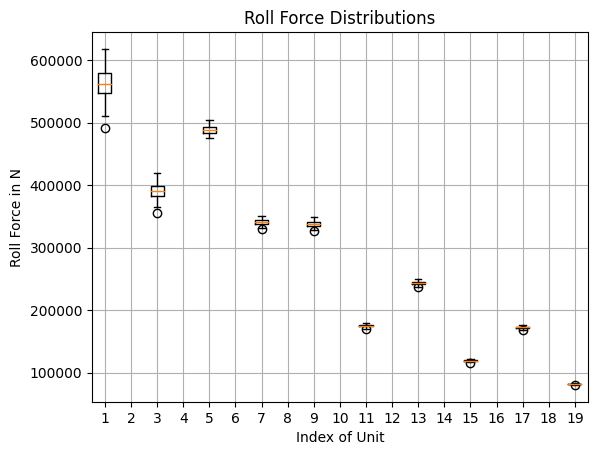

In [22]:
fig: plt.Figure = plt.figure()
ax: plt.Axes = fig.add_subplot()

ax.set_title(r"Roll Force Distributions")
ax.set_xlabel("Index of Unit")
ax.set_ylabel("Roll Force in N")
ax.grid(True)

ax.boxplot(data.roll_force);

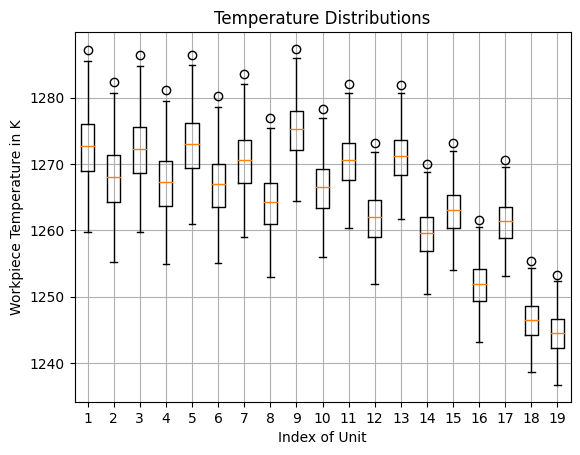

In [20]:
fig: plt.Figure = plt.figure()
ax: plt.Axes = fig.add_subplot()

ax.set_title(r"Temperature Distributions")
ax.set_xlabel("Index of Unit")
ax.set_ylabel("Workpiece Temperature in K")
ax.grid(True)

ax.boxplot(data.temperature);

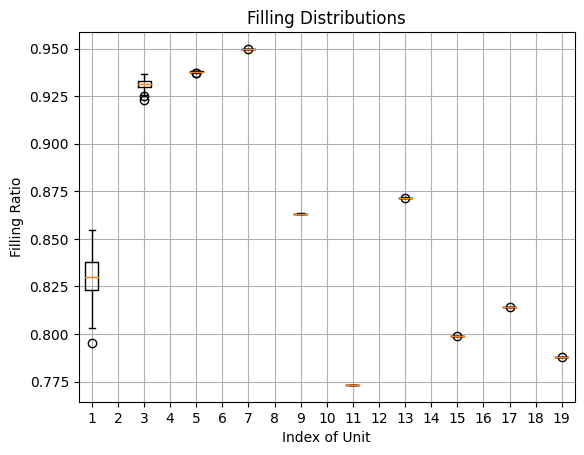

In [19]:
fig: plt.Figure = plt.figure()
ax: plt.Axes = fig.add_subplot()

ax.set_title(r"Filling Distributions")
ax.set_xlabel("Index of Unit")
ax.set_ylabel("Filling Ratio")
ax.grid(True)

ax.boxplot(data.filling_ratio);

As we see the variations decrease along the sequence.
Especially for the filling ratio, the result is almost independent of the tolerances in the initial profile.